# Create a regular gridded dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
import pyproj
from pathlib import Path
import tarfile
from io import StringIO

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Crop survey area

In [3]:
tar_path = Path('../data/1038_XYZ.tar.xz')
file_path = Path('1038_XYZ/1038/spaulo_rjaneiro_rj.xyz')
file_content = None
with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if Path(member.name) == file_path:
            file_content = tar.extractfile(member).read().decode('ISO-8859-1')
            break
if file_content is None:
    raise FileNotFoundError(f"The specified file '{file_path}' was not found in the tar archive.")

lines = file_content.splitlines()
filtered_lines = [line for line in lines if not (line.startswith('LINE') or line.startswith('TIE'))]
filtered_data = '\n'.join(filtered_lines)
filtered_data_io = StringIO(filtered_data)

column_names = [
    'easting_m', 'northing_m', 'longitude', 'latitude', 'tfa_nT', 'THC', 'UC', 'KC', 'CTC', 
    'MAGB', 'MAGC', 'MAGD', 'THB', 'UB', 'KB', 'CTB', 'FIDU', 'TEMP', 
    'height_m', 'ALTB'
]
use_columns = [
    'longitude', 'latitude', 'tfa_nT', 'height_m',
]
df = pd.read_csv(filtered_data_io, 
                 delim_whitespace=True,
                 names=column_names,
                 usecols=use_columns,
                 skiprows=6)
df

,longitude,latitude,tfa_nT,height_m
0,-43.995255,-23.099503,434.32,300.00
1,-43.995224,-23.098618,426.28,300.00
2,-43.995193,-23.097733,418.24,300.00
3,-43.995178,-23.096832,410.20,300.00
4,-43.995148,-23.095947,402.16,300.00
...,...,...,...,...
433231,-41.949890,-20.818878,184.03,241.71
433232,-41.950882,-20.818909,179.13,241.10
433233,-41.951859,-20.818909,174.23,238.66
433234,-41.952850,-20.818924,167.32,234.70


In [4]:
# Crop area
region = [-42.9, -42.0, -22.6, -22.0]
mask = vd.inside(coordinates=[df.longitude, df.latitude], region=region)
data = df[mask]

In [5]:
# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = [easting, northing, data.height_m]

data = data.assign(easting_m=easting)
data = data.assign(northing_m=northing)
data

,longitude,latitude,tfa_nT,height_m,easting_m,northing_m
118382,-42.899185,-22.454605,3.03,188.37,-4.420542e+06,-2.360343e+06
118383,-42.899216,-22.453720,6.02,197.82,-4.420546e+06,-2.360245e+06
118384,-42.899246,-22.452835,7.02,205.44,-4.420549e+06,-2.360147e+06
118385,-42.899277,-22.451950,7.01,208.18,-4.420552e+06,-2.360049e+06
118386,-42.899307,-22.451065,7.01,205.74,-4.420555e+06,-2.359951e+06
...,...,...,...,...,...,...
422362,-42.023544,-22.073761,6.20,269.75,-4.330312e+06,-2.318181e+06
422363,-42.024536,-22.073776,16.26,263.96,-4.330414e+06,-2.318183e+06
422364,-42.025513,-22.073776,30.33,255.73,-4.330515e+06,-2.318183e+06
422365,-42.026505,-22.073776,46.39,247.19,-4.330617e+06,-2.318183e+06


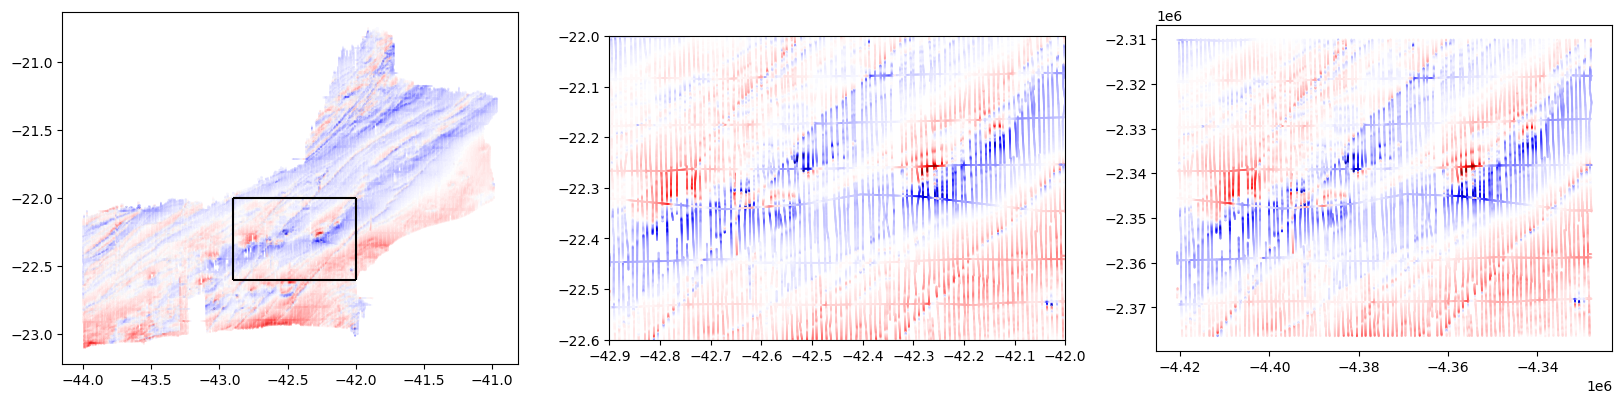

In [6]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(df.longitude, df.latitude, s=0.001, c=df.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.vlines(x=[region[0], region[1]], ymin=region[2], ymax=region[3], color='black')
plt.hlines(y=[region[2], region[3]], xmin=region[0], xmax=region[1], color='black')
plt.subplot(1,3,2)
plt.scatter(data.longitude, data.latitude, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.xlim(region[0], region[1])
plt.ylim(region[2], region[3])
plt.subplot(1,3,3)
plt.scatter(data.easting_m, data.northing_m, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.show()

## Interpolate data onto a regular grid using GB EQS

In [60]:
damping = 2e3
depth = 1.5e3
grid_spacing = 0.1e3

eqs = hm.EquivalentSourcesGB(
    depth=depth,
    damping=damping,
    block_size=grid_spacing,
    window_size=10e3,
    random_state=0,
)

In [61]:
eqs.fit(coordinates, data.tfa_nT)

EquivalentSourcesGB(block_size=100.0, damping=2000.0, depth=1500.0,
                    random_state=0, window_size=10000.0)

In [62]:
grid_region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=grid_region,
    spacing=grid_spacing,
    extra_coords=data.height_m.max(),
)
grid_tfa_nT = eqs.predict(grid_coords)

In [63]:
grid_data = vd.make_xarray_grid(grid_coords, data=grid_tfa_nT, data_names="tfa_nT", dims=('northing_m', 'easting_m'), extra_coords_names='height_m')
grid_data

<xarray.Dataset> Size: 10MB
Dimensions:     (northing_m: 665, easting_m: 928)
Coordinates:
  * easting_m   (easting_m) float64 7kB -4.421e+06 -4.421e+06 ... -4.328e+06
  * northing_m  (northing_m) float64 5kB -2.376e+06 -2.376e+06 ... -2.31e+06
    height_m    (northing_m, easting_m) float64 5MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nT      (northing_m, easting_m) float64 5MB 123.5 124.8 ... 114.7 113.7

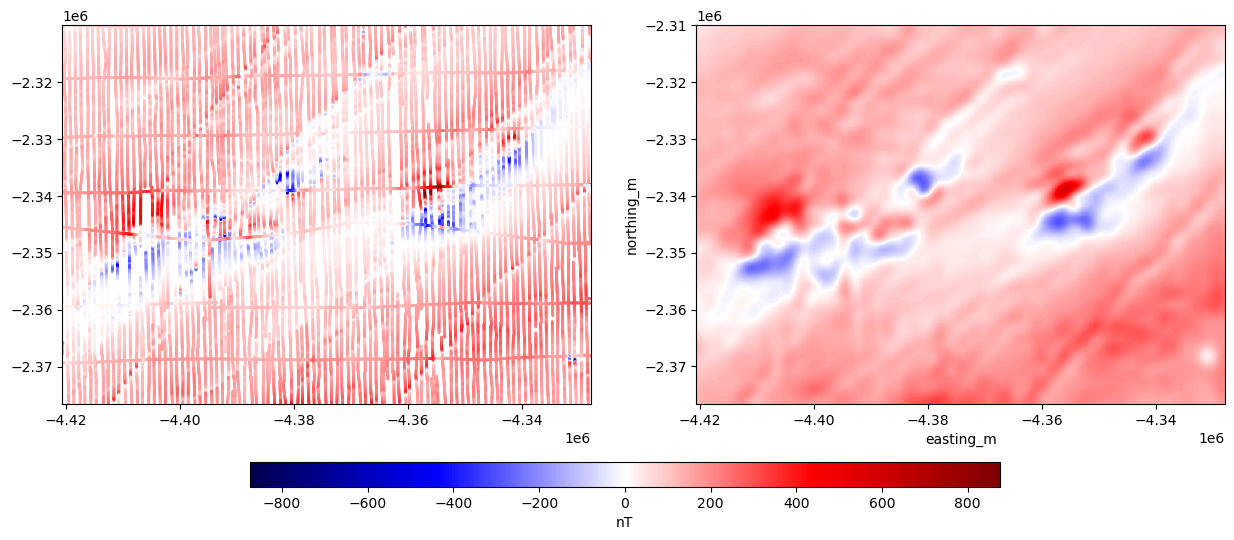

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
ax = axes[0]
scale = vd.maxabs(data.tfa_nT)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_nT,
    s=1,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
)
ax.set_xlim(grid_region[0], grid_region[1])
ax.set_ylim(grid_region[2], grid_region[3])
ax.set_aspect("equal")

ax = axes[1]
tmp = grid_data.tfa_nT.plot.pcolormesh(
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
fig.colorbar(tmp, **cbar_kwargs,  label="nT", cax=fig.add_axes([0.25, -0.05, 0.5, 0.05]))
plt.show()

## Save data

In [65]:
data_path = Path('../data/rio-magnetic.nc') 
grid_data.to_netcdf(data_path)